<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/FFN/DUDL_FFN_shiftedMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

In [3]:
# Import dataset
mnist_dataset = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'), delimiter=',')

#Extract labels (number IDs) and remove from data
labels = mnist_dataset[:, 0]
data   = mnist_dataset[:, 1:]

# Normalize the data to a range of [0, 1]
data_norm = data / np.max(data)

# Create train/test groups using DataLoader

In [4]:
# Step 1: Convert to tensor
data_tensor   = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

# Step 2: Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(data_tensor, labels_tensor, test_size=0.1)

# Step 3: Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Step 4: Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

# How many batches are there?
print(f'There are {len(train_loader)} batches, each with {batch_size} samples')

There are 562 batches, each with 32 samples


# Shift the test images by a few pixels

In [14]:
print(train_loader.dataset.tensors) # All the images + All the labels
print(test_loader.dataset.tensors[0].shape)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([3, 6, 4,  ..., 0, 5, 3]))
torch.Size([2000, 784])


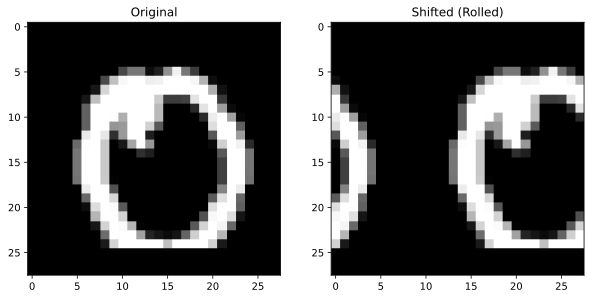

In [9]:
# First let's see how to shift a vectorized image
# print(test_loader.dataset.tensors[0].shape)
# Grab one image data
temp = test_loader.dataset.tensors[0][0, :]
# Reshape to 2D image
temp = temp.reshape(28, 28)

# Shift the image (pytorch calls it "rolling")
temp_shift = torch.roll(temp, shifts=8, dims=1)

# Now show them both
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(temp, cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(temp_shift, cmap='gray')
ax[1].set_title('Shifted (Rolled)')

plt.show()

In [10]:
# Now repeat for all images in the test set

for i in range(test_loader.dataset.tensors[0].shape[0]):

  # Get the image
  img = test_loader.dataset.tensors[0][i, :]

  # Reshape and roll by max. 10 pixels
  rand_roll = np.random.randint(-10, 11)
  img       = torch.roll(img.reshape(28, 28), shifts=rand_roll, dims=1)

  # Re-vectorize and put back into the matrix 
  test_loader.dataset.tensors[0][i, :] = img.reshape(1, -1)

# Note: now run the previous cell again to confirm the shifting

# Create the DL model

In [11]:
def create_the_MNIST_net():
    """"
    FFN_SCRAMBLEDMNIST | FFN_SHIFTEDMNIST
    """
    class mnist_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output layer
            self.output = nn.Linear(32, 10)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)
        
    # Create the model instance
    net = mnist_net()

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, loss_func, optimizer


# Create a function that trains the model

In [12]:
def train_the_model():
    """
    FFN_SHIFTEDMNIST
    """
    
    num_epochs = 50

    # Create a new model
    net, loss_func, optimizer = create_the_MNIST_net()

    # Initialize
    losses    = torch.zeros(num_epochs)
    train_acc = []
    test_acc  = []

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training data batches
        batch_acc  = []
        batch_loss = [] 

        for X, y in train_loader:
            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batch_loss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(y_hat, axis=1) == y       # Booleans (True/False)
            matches_numeric = matches.float()                # Convert to numbers (1/0)
            accuracy_pct = 100 * torch.mean(matches_numeric) # Average and *100
            batch_acc.append(accuracy_pct)                   # Add to list of accuracies
        # End of batch loop.

        # Get the average training accuracy of the batches
        train_acc.append(np.mean(batch_acc))

        # The average losses accross the batches
        losses[epoch_i] = np.mean(batch_loss)

        # Test accuracy
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        with torch.no_grad():
          y_hat = net(X)
        test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

    # End epochs

    return train_acc, test_acc, losses, net

# Run the model and show the results!

In [13]:
train_acc, test_acc, losses, net = train_the_model()

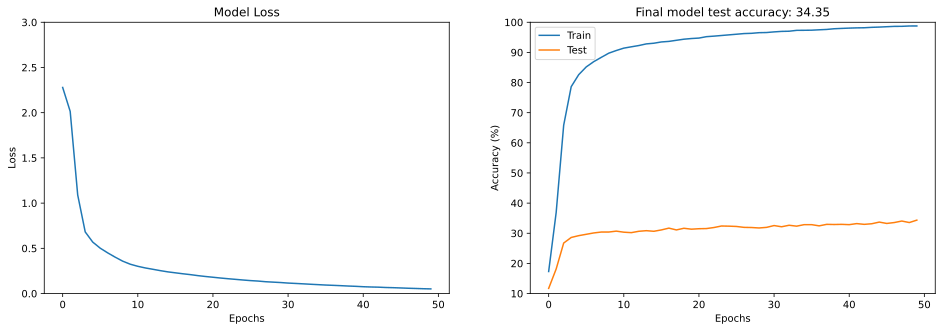

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc,  label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}')
ax[1].legend()

plt.show()

# Optional explorations
1) You saw that shifting by max-10 pixels has negative effects on model generalization. What do you think will happen
   if you shift the images by 4 pixels? 3? 2? 1? Try it and find out!

2) Dropout regularization helps make representations more distributed. Can that help with the decrease in learning?
   Try this by testing the model on 2-pixel shifted images with and without 50% dropout.

3) Continue exploring the torch.roll() function. Make sure you know how to shift up and down, not just left/right.